## Construção do modelo de clustering:
🎯 Objetivo
Segmentar os clientes em grupos homogêneos usando K‑Means, com base em características demográficas e comportamentais.

In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "9" #evitar o warning do kmeans
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.ticker import PercentFormatter

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder, 
    MinMaxScaler, 
    OneHotEncoder, 
    PowerTransformer,
    StandardScaler,
)

from src.config import (
    ORIGINAL_DATA,  
    TREATED_DATA, 
    MODEL_CLUSTERING, 
    CLUSTERED_DATA
)

from src.graphics import (
    pairplot,
    plot_elbow_silhouette, 
    plot_clusters_2D, 
    plot_columns_percent_by_cluster,
    plot_columns_percent_hue_cluster
)
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classifier,
    train_and_validate_classification_model,
    organize_cv_results,
)

sns.set_theme(palette='tab10')


In [2]:
df = pd.read_parquet(TREATED_DATA)

df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,Days_Since_Enrolled,Years_Since_Enrolled,Age_Grouped,Mnt_Total,Mnt_Regular,Children,Has_Children,AcceptedCmpTotal,HasAcceptedCmp
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,57,663,1,46-60,1617,1529,0,0,0,0
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,60,113,0,46-60,27,21,2,1,0,0
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,49,312,0,46-60,776,734,0,0,0,0
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,30,139,0,18-30,53,48,1,1,0,0
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,33,161,0,31-45,422,407,1,1,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212 entries, 0 to 2211
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Education             2212 non-null   object  
 1   Marital_Status        2212 non-null   object  
 2   Income                2212 non-null   float64 
 3   Kidhome               2212 non-null   int64   
 4   Teenhome              2212 non-null   int64   
 5   Recency               2212 non-null   int64   
 6   MntWines              2212 non-null   int64   
 7   MntFruits             2212 non-null   int64   
 8   MntMeatProducts       2212 non-null   int64   
 9   MntFishProducts       2212 non-null   int64   
 10  MntSweetProducts      2212 non-null   int64   
 11  MntGoldProds          2212 non-null   int64   
 12  NumDealsPurchases     2212 non-null   int64   
 13  NumWebPurchases       2212 non-null   int64   
 14  NumCatalogPurchases   2212 non-null   int64   
 15  NumS

In [4]:
# Agrupamento das colunas numéricas
numerical_features = list(df.select_dtypes("number").columns)
len(numerical_features)

31

#### 🔍 Inspeção Inicial das Distribuições
Histogramas das variáveis numéricas para entender formatos e identificar transformações:

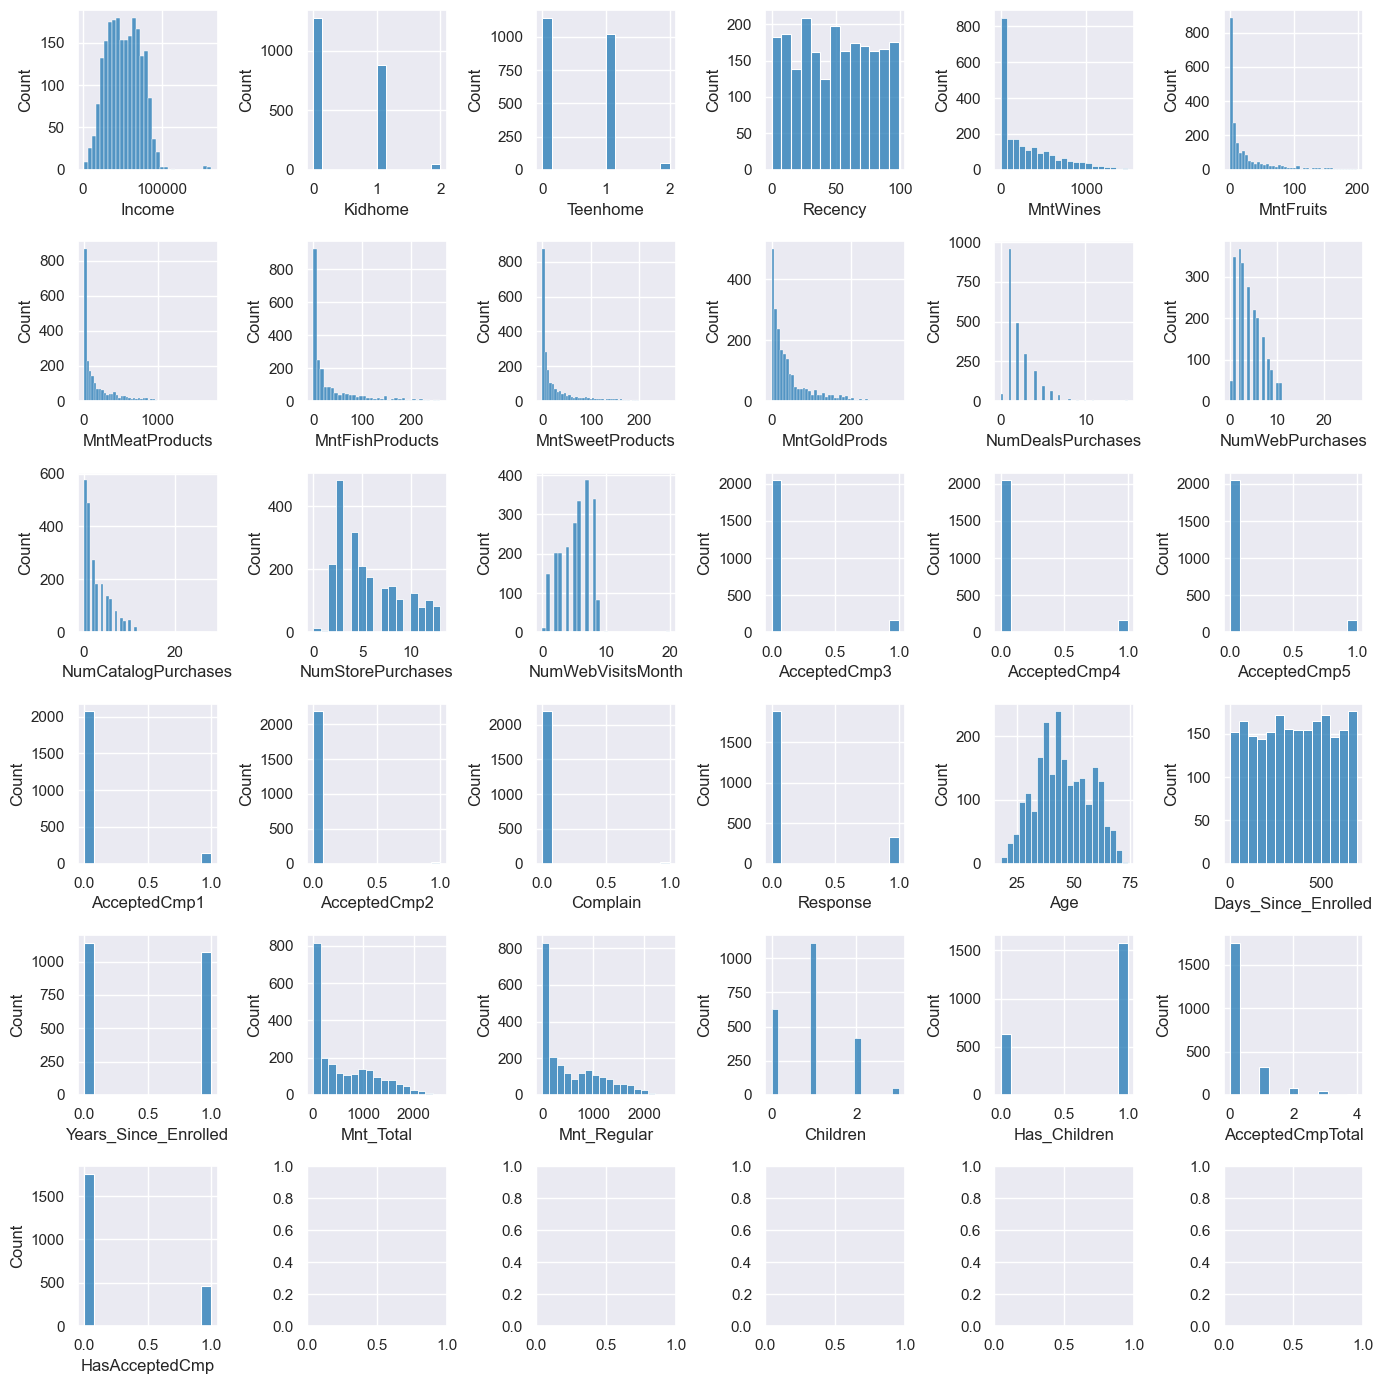

In [5]:
#análise da distribuição dos dados para escalonamento das features
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(14,14), tight_layout=True)

for ax, feature in zip(axs.flatten(), numerical_features):
    sns.histplot(x=feature, ax=ax, data=df)
plt.show()

#### Fluxo da Análise:

##### 1. Pré-processamento dos Dados:
Transformação de Variáveis:

* Variáveis categóricas: serão codificadas via OneHotEncoder

* Variáveis Age e Income: estão próximas da distribuiçõa normal. O StandarScaler é uma boa opção nesse caso.

* Variáveis Days Since Enrolled e Recency: possuem distribuição uniforme. O MinMaxScaler irá colocar dentro da escala (padrão 0 e 1)

* Variáveis Num e Mnt: a distribuição enviesada, usarei o Power Transformer para deixar a distribuição mais próxima do normal



In [6]:
numerical_features 

['Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Response',
 'Age',
 'Days_Since_Enrolled',
 'Years_Since_Enrolled',
 'Mnt_Total',
 'Mnt_Regular',
 'Children',
 'Has_Children',
 'AcceptedCmpTotal',
 'HasAcceptedCmp']

In [7]:
#colunas categóricas
one_hot_cols=[
    'Education',
    'Marital_Status',
    'Age_Grouped',
    'Kidhome',
    'Teenhome',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5',
    'AcceptedCmp1',
    'AcceptedCmp2',
    'Complain',
    'Response',
    'Years_Since_Enrolled',
    'Has_Children',
    'Children',
    'AcceptedCmpTotal',
    'HasAcceptedCmp',
]



#colunas com a distruibuição próxima a normal
standard_cols= [
    'Income',
    'Age'
]

power_cols= df.columns[
df.columns.str.startswith("Mnt") | df.columns.str.startswith("Num")
].tolist()

minmax_cols = [
    col for col in df.columns if col not in one_hot_cols + standard_cols + power_cols
]

In [8]:
# Preprocessamento
preprocessing = ColumnTransformer(
    [
        ("one_hot", OneHotEncoder(drop='first'), one_hot_cols),  #"first"
        ("PowerTransformer",PowerTransformer(), power_cols),     
        ("standard", StandardScaler(), standard_cols), 
        ("minmax",MinMaxScaler(), minmax_cols), 
    ]
)
 

#### Visualização das distribuições escalonadas

Aplicação do fit_transform

In [9]:
# criar dataframe com os dados preprocessados
df_scaled = pd.DataFrame(
    preprocessing.fit_transform(df),
    columns= preprocessing.get_feature_names_out(),
)


In [10]:
#pegar todas as colunas que não foram processadas pelo one_hot
scaled_columns_not_one_hot = df_scaled.columns[~df_scaled.columns.str.startswith('one')]
scaled_columns_not_one_hot

Index(['PowerTransformer__MntWines', 'PowerTransformer__MntFruits',
       'PowerTransformer__MntMeatProducts',
       'PowerTransformer__MntFishProducts',
       'PowerTransformer__MntSweetProducts', 'PowerTransformer__MntGoldProds',
       'PowerTransformer__NumDealsPurchases',
       'PowerTransformer__NumWebPurchases',
       'PowerTransformer__NumCatalogPurchases',
       'PowerTransformer__NumStorePurchases',
       'PowerTransformer__NumWebVisitsMonth', 'PowerTransformer__Mnt_Total',
       'PowerTransformer__Mnt_Regular', 'standard__Income', 'standard__Age',
       'minmax__Recency', 'minmax__Days_Since_Enrolled'],
      dtype='object')

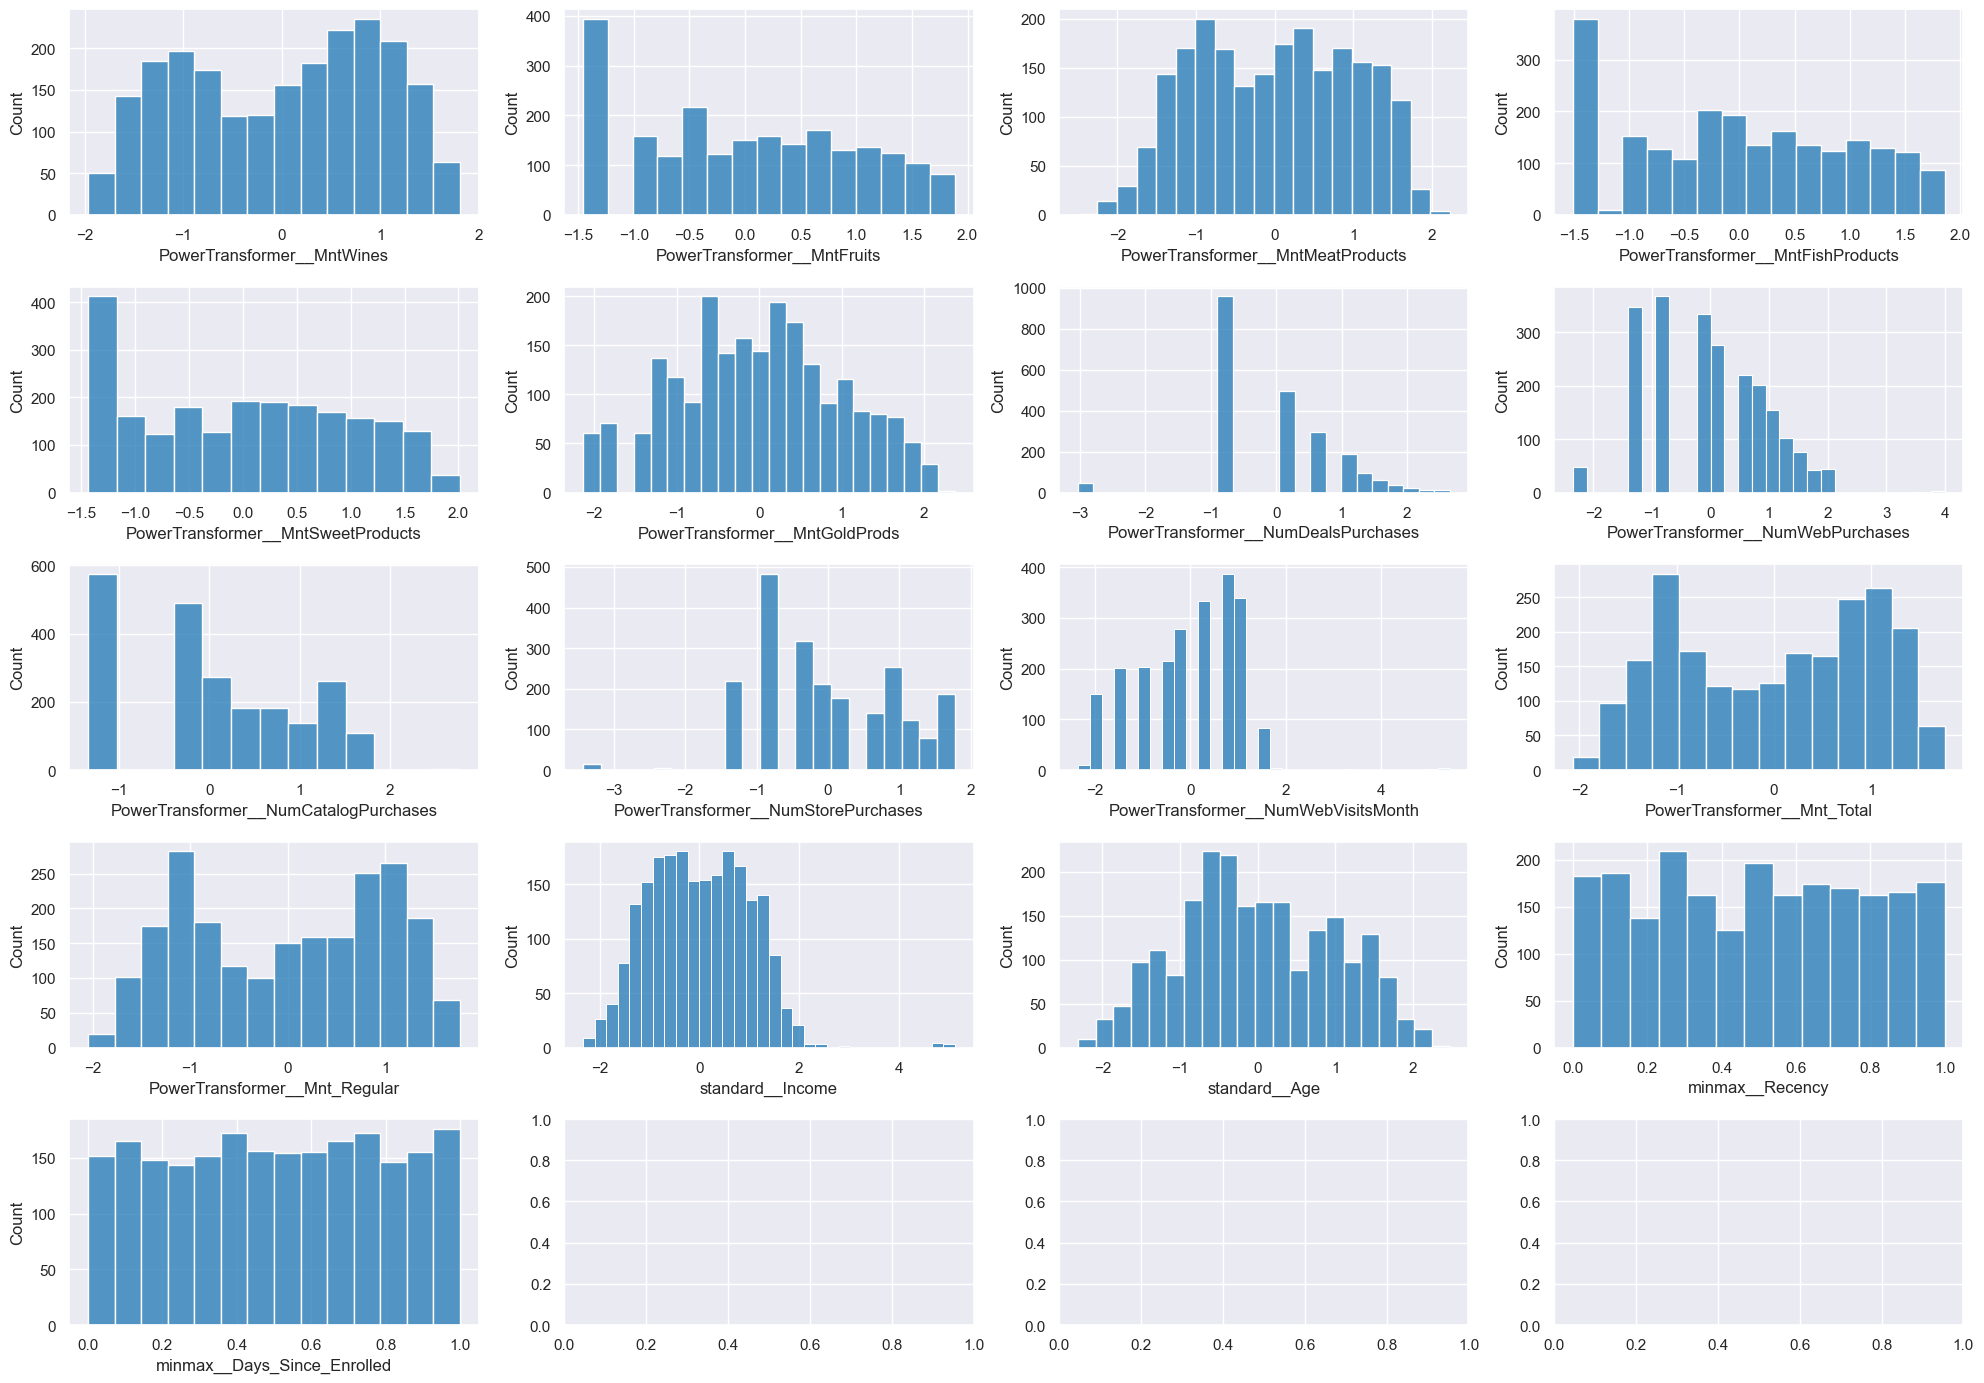

In [11]:
#análise da distribuição dos dados para escola do feature scaling
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(20,14), tight_layout=True)

for ax, feature in zip(axs.flatten(), scaled_columns_not_one_hot):
    sns.histplot(x=feature, ax=ax, data=df_scaled)
plt.show()

##### 2. Determinação do Número Ótimo de Clusters:
 
Método Elbow e Silhouette Score e análise dos dados através da análise exploratória

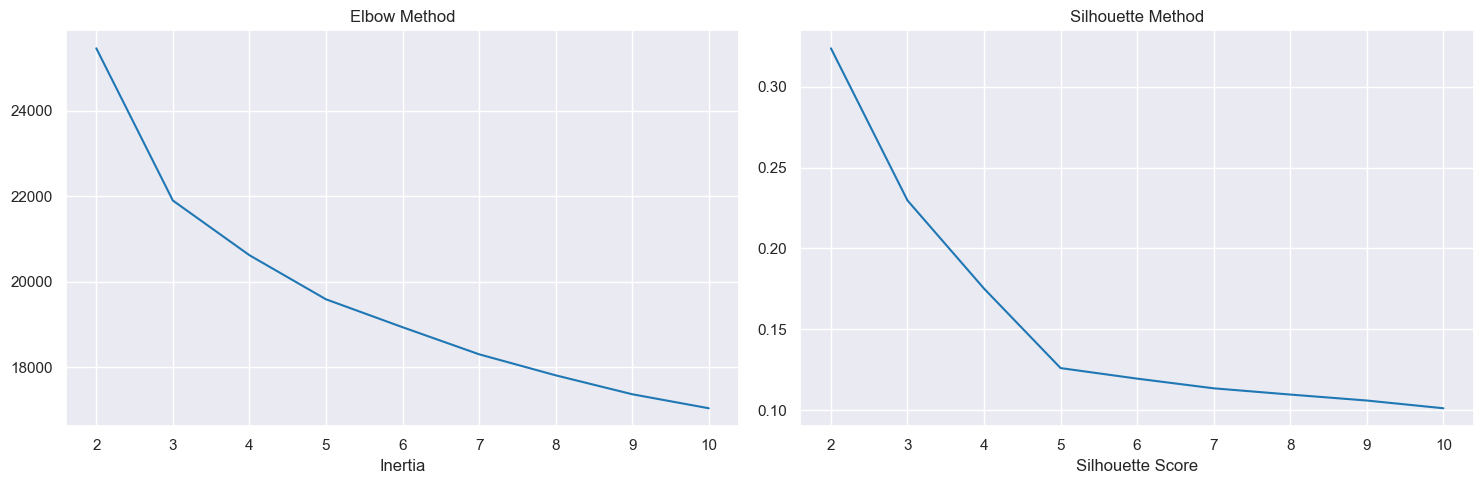

In [12]:
#função que cria gr
plot_elbow_silhouette(df_scaled)            

O método elbow indica entre 3 clusters, já o silhouete indica 2.
Em conjunto com insights da análise exploratória, foi feita a opção por 3 clusters.

##### 3. Aplicação do K-Means 
   
Modelo treinado com n_clusters=3 e random_state=42 para reprodutibilidade.

🧭 Construção do Pipeline Final com K‑Means (integrando pré-processamento e modelagem)

In [13]:
# Pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('kmeans', KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10))  
])

In [14]:
#fazer o fit do dataframe original
pipeline.fit(df)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Education',
                                                   'Marital_Status',
                                                   'Age_Grouped', 'Kidhome',
                                                   'Teenhome', 'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2', 'Complain',
                                                   'Response',
                                                   'Years_Since_Enrolled',
                                                   'Has_Children', 'Children',
                                                   'AcceptedCmpTotal',
                                                   'HasAcceptedCmp'...
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'Mnt_Total',
                                                   'Mnt_Regular']),
                                                 ('standard', StandardScaler(),
                                                  ['Income', 'Age']),
                                                 ('minmax', MinMaxScaler(),
                                                  ['Recency',
                                                   'Days_Since_Enrolled'])])),
                ('kmeans', KMeans(n_clusters=3, n_init=10, random_state=42))])

In [15]:
#para visualizar os dados originais clusterizados
df_clustered = df.copy()
df_clustered['Cluster']=  pipeline.named_steps['kmeans'].labels_
df_clustered.to_parquet(CLUSTERED_DATA, index=False)
df_clustered.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Days_Since_Enrolled,Years_Since_Enrolled,Age_Grouped,Mnt_Total,Mnt_Regular,Children,Has_Children,AcceptedCmpTotal,HasAcceptedCmp,Cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,663,1,46-60,1617,1529,0,0,0,0,1
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,113,0,46-60,27,21,2,1,0,0,0
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,312,0,46-60,776,734,0,0,0,0,1
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,139,0,18-30,53,48,1,1,0,0,0
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,161,0,31-45,422,407,1,1,0,0,2


In [16]:
df_clustered['Cluster'].value_counts().sort_index()

Cluster
0    879
1    675
2    658
Name: count, dtype: int64

In [17]:
#tamanho de cada cluster
df_clustered["Cluster"].value_counts(normalize=True).mul(100).sort_index()


Cluster
0    39.737794
1    30.515371
2    29.746835
Name: proportion, dtype: float64

##### 🔬 Visualização dos Clusters
Pairplot em variáveis chaves:

In [18]:
#variáveis chaves
columns_overview = [
    'Income', 
    'Recency',
    'Age',
    'Days_Since_Enrolled',	
    'Mnt_Total',     
]


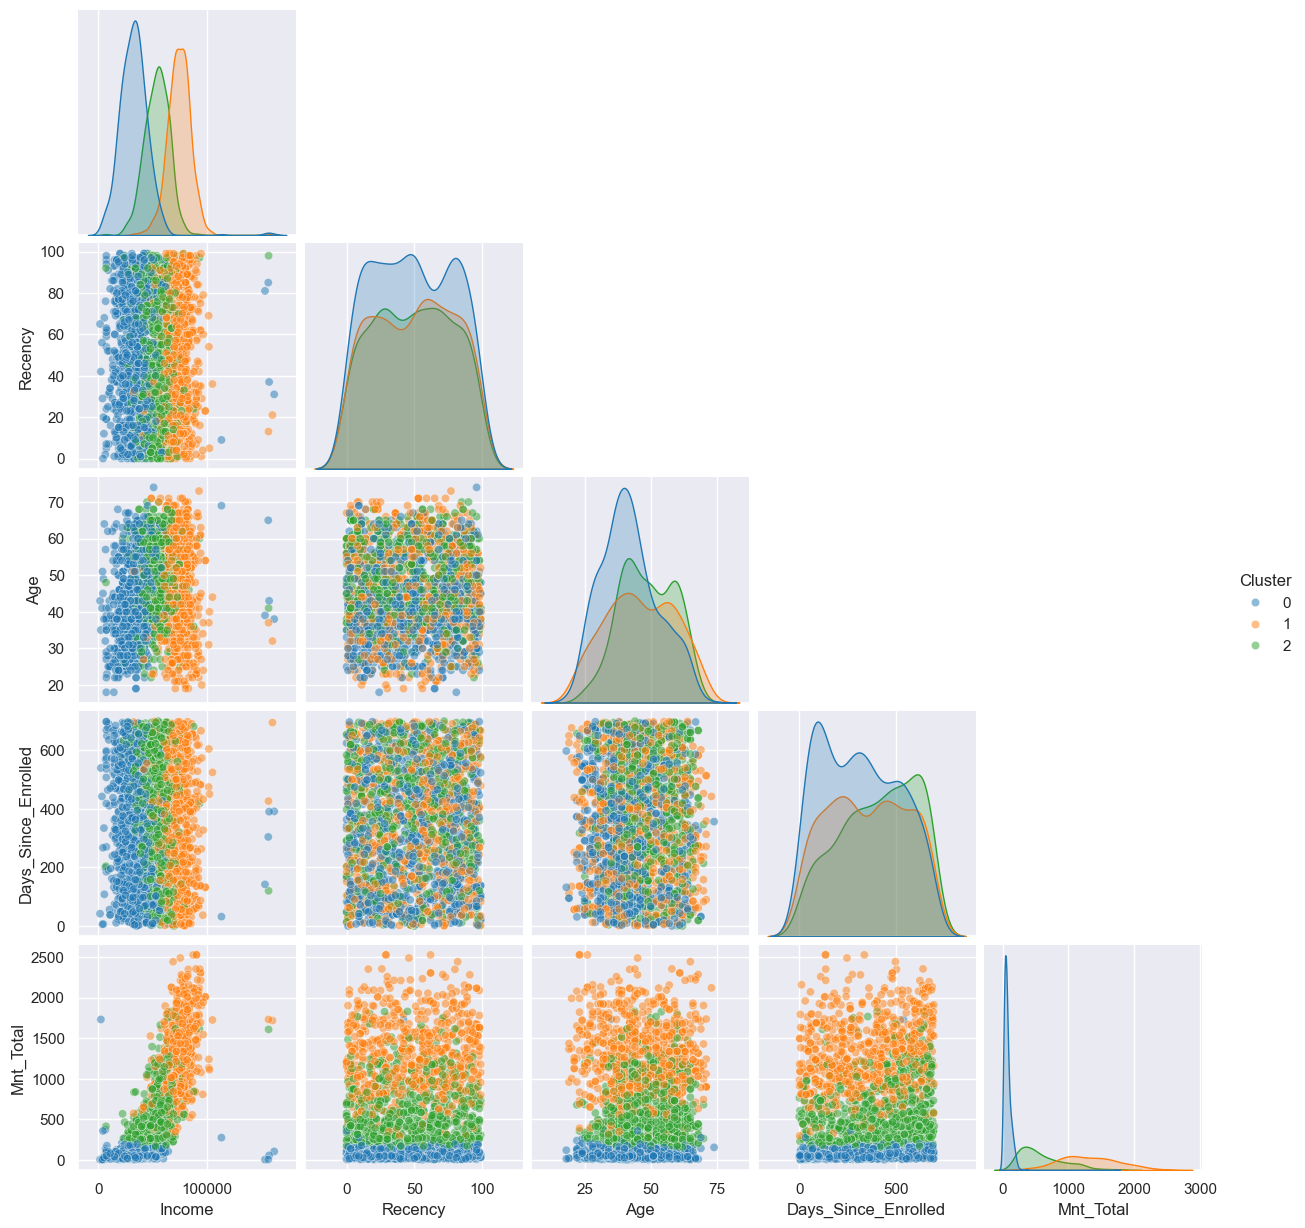

In [19]:
# Criar o pairplot visualizando a distribuição dos clusters. 
pairplot(df_clustered, columns_overview, hue_column='Cluster')


O gráfico acima ajuda a entender a distribuição dos clusters, há uma indicação clara que a renda foi o principal critério na clusterização.
Já havia sido observado na análise exploratória a relação entre gastos, aceites de campanha e renda.

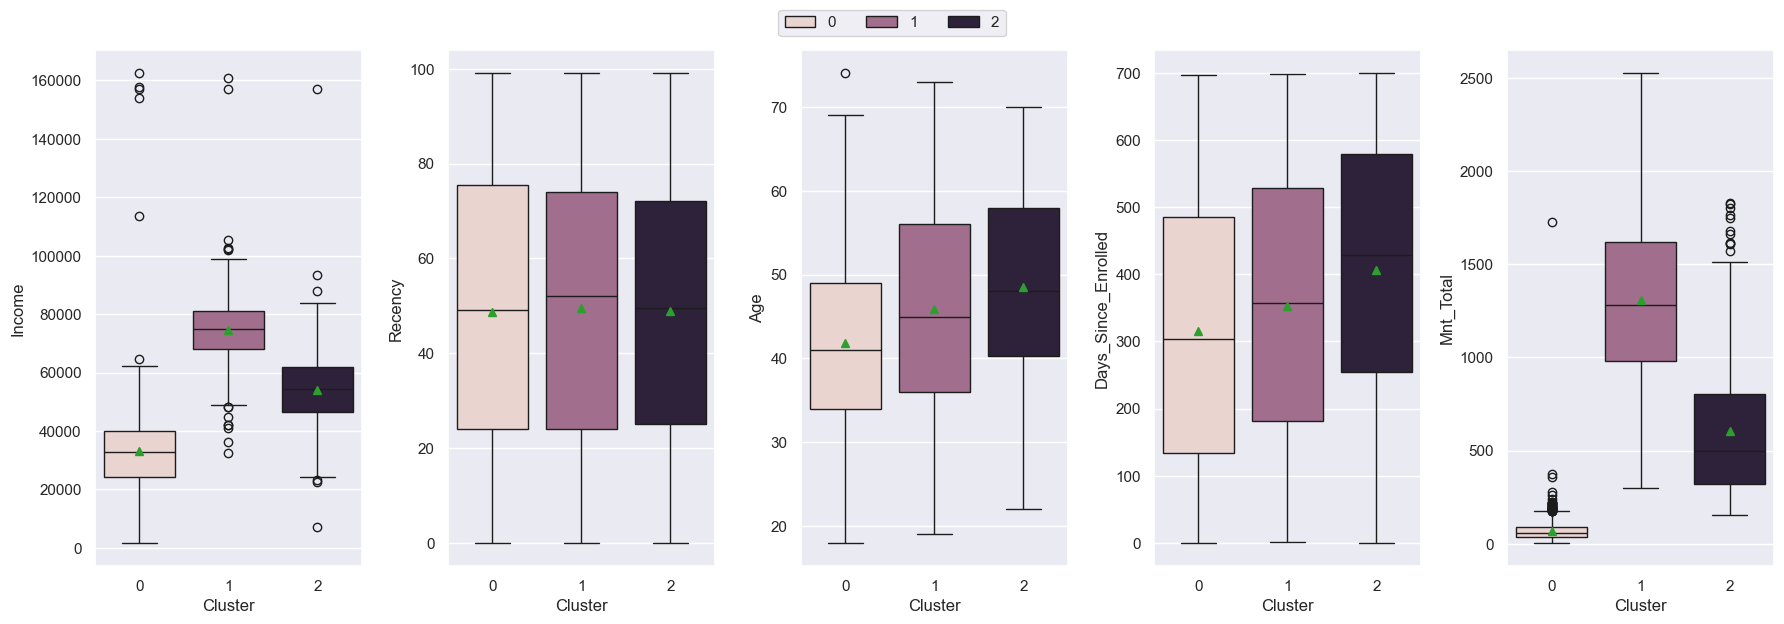

In [20]:
#análise boxplots
fig, axs = plt.subplots(1, 5, figsize=(18, 6))

# Criar os boxplots sem legendas individuais
for ax, column in zip(axs.flatten(), columns_overview):
    sns.boxplot(y=column, ax=ax, data=df_clustered, showmeans=True, x="Cluster", hue="Cluster")
    ax.get_legend().remove()  # Remove a legenda individual de cada subplot

# Pegar os handles e labels de um dos subplots para criar a legenda única
handles, labels = axs[0].get_legend_handles_labels()

# Adicionar uma única legenda centralizada no topo
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.show()

##### Observações

Análise dos boxplots confirma a relação entre fator financeiro e gastos totais como principais fatores distintos de cada cluster


* Cluster 0: menor renda, mais novos, menores gastos, menor média etária.

* Cluster 1: maior renda, maiores gastos e altos gastos, média etária mediana.

+ Cluster 2: perfil intermediário, maior média etária.



In [21]:
#análise perfil_consumo
colunas_excluidas = ['Mnt_Total', 'Mnt_Regular'] 
perfil_consumo = [col for col in df_clustered.columns[df_clustered.columns.str.startswith("Mnt")].tolist() 
                  if col not in colunas_excluidas]
perfil_consumo

['MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds']

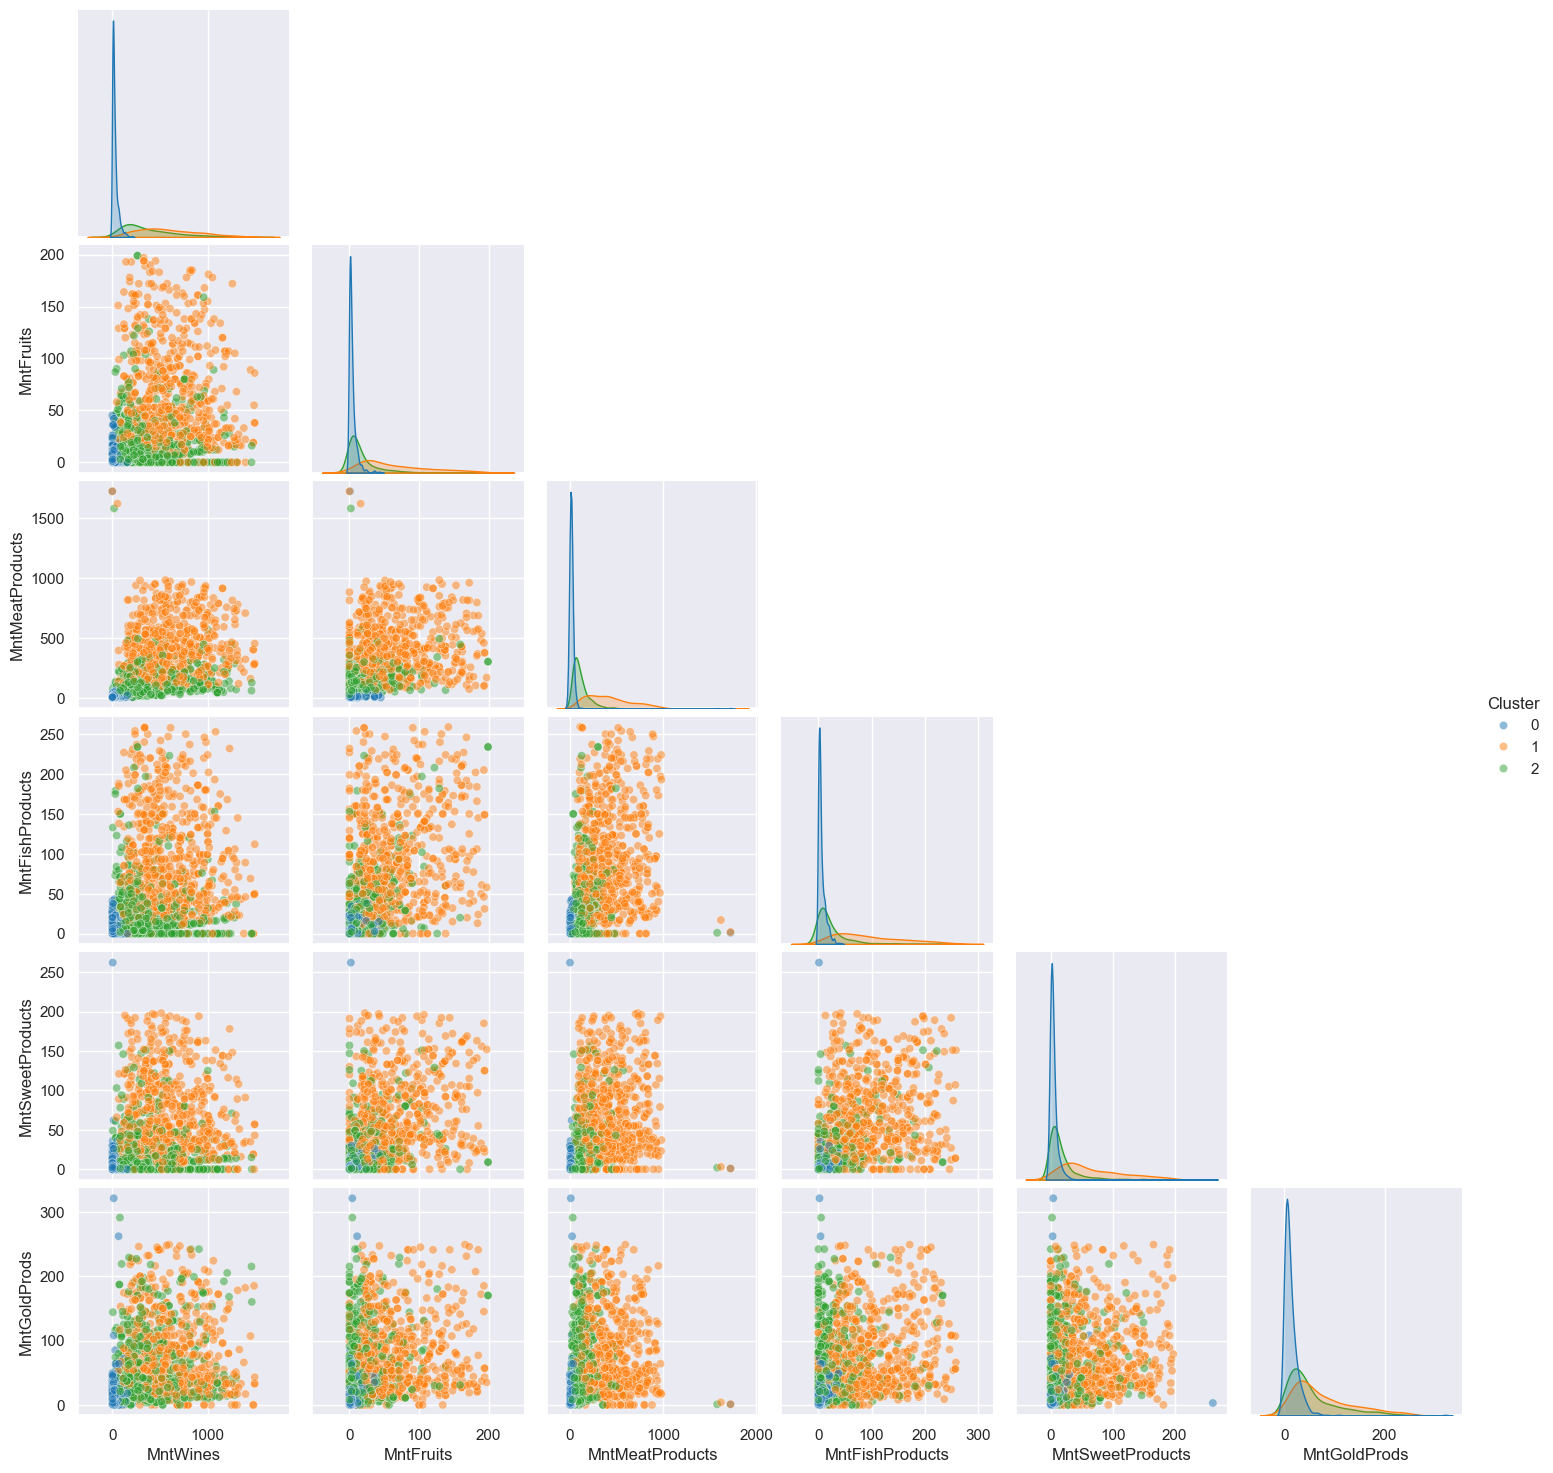

In [22]:
# Criar o pairplot visualizando a distribuição dos clusters. 
pairplot(df_clustered, perfil_consumo, hue_column='Cluster')

#### Observações 
- os maiores gastos com peixe, carne e vinho foram feitos pelo Cluster 1
- os maiores gastos com produtos gold e doces foram feitos pelos Cluster 1 e 2
- os menores gastos em todas as categorias foram feitos pelo Cluster 0

In [23]:
#análise perfil de compras
colunas_excluidas_compras = ['NumDealsPurchases'] 
perfil_compras = [col for col in df_clustered.columns[df_clustered.columns.str.startswith("Num")].tolist() if col not in colunas_excluidas_compras]
perfil_compras

['NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth']

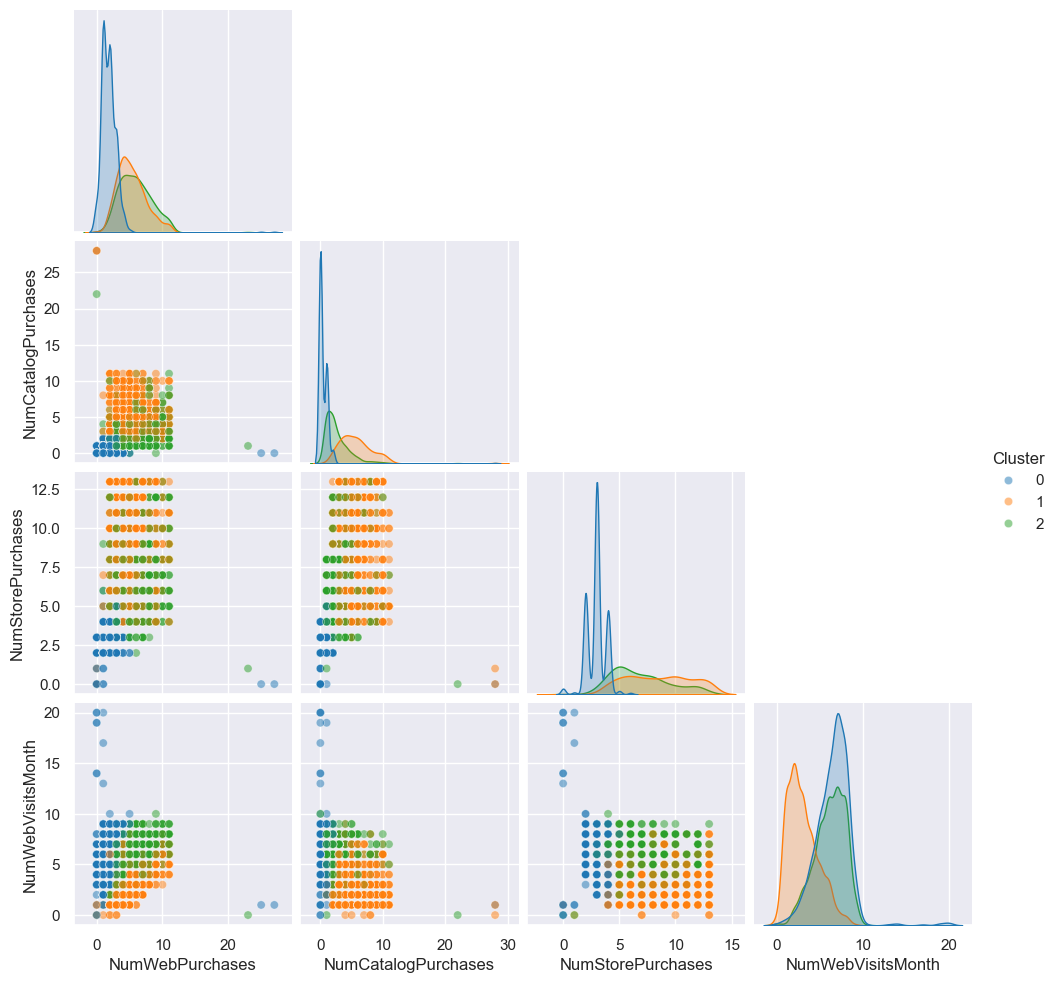

In [24]:
# Criar o pairplot visualizando a distribuição dos clusters. 
pairplot(df_clustered, perfil_compras, hue_column='Cluster')

#### Observações 

- As pessoas do Cluster 0 e 2 fazem mais visitas ao websit, embora os clientes agrupados no Cluster 1 e 2 façam mais compras tanto na web, quanto catálago e lojas.

##### Análise das colunas categóricas mais relevantes

In [25]:
categorical_columns = [
    'Has_Children',
    'Age_Grouped',
    'Education',
    'HasAcceptedCmp',
    'Response',
    'Years_Since_Enrolled'	
]

#agrupamento das colunas que mostraram uma grande diferenciação com a clusterização
cluster_diff_cols = ['Mnt_Total', 'Income']


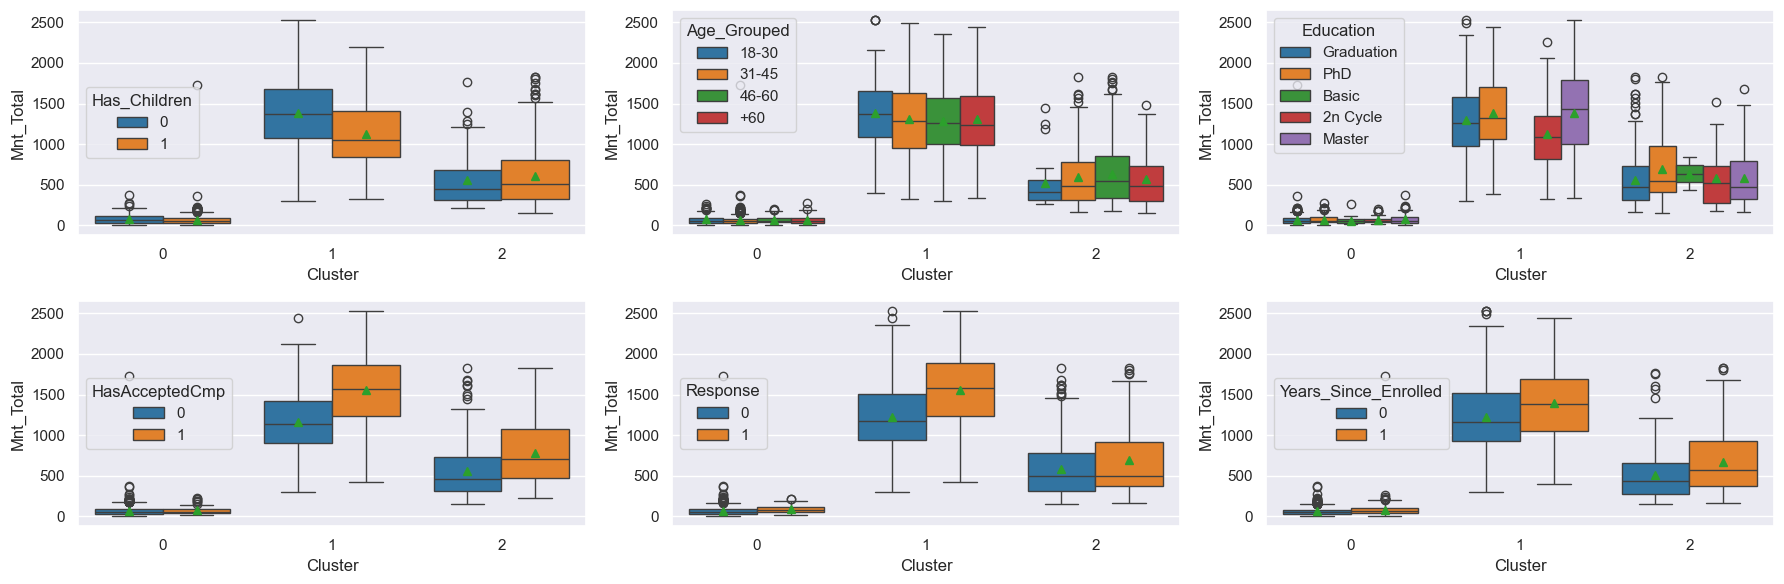

In [26]:
#análise boxplots
fig, axs = plt.subplots(2, 3, figsize=(18, 6))

# Criar os boxplots sem legendas individuais
for ax, column in zip(axs.flatten(), categorical_columns):
    sns.boxplot(y=cluster_diff_cols[0], ax=ax, data=df_clustered, showmeans=True, x="Cluster", hue=column)



plt.tight_layout()
plt.show()

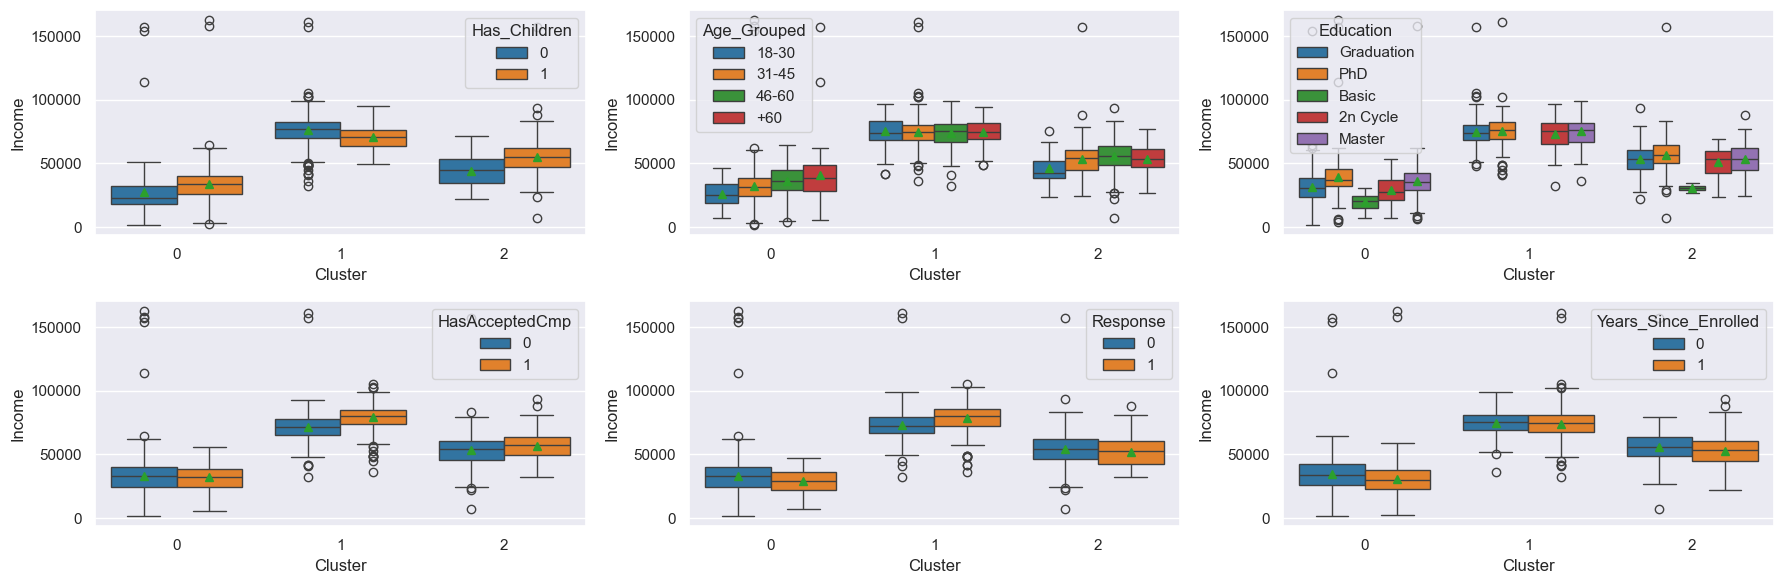

In [27]:
#análise boxplots
fig, axs = plt.subplots(2, 3, figsize=(18, 6))


for ax, column in zip(axs.flatten(), categorical_columns):
    sns.boxplot(y=cluster_diff_cols[1], ax=ax, data=df_clustered, showmeans=True, x="Cluster", hue=column)



plt.tight_layout()
plt.show()

#### Observações
A segmentação entre as fetaures categóricas não foi tão grande, mas é possível notar que pessoas do Cluster 1 (maior renda e maiores gastos) têm melhores índices de aceite de oferta de campanha, response. Esse Cluster também é o único em que pessoas sem filhos gastam mais e possuem uma renda maior.

Não há diferença significativa em relação ao estado civil


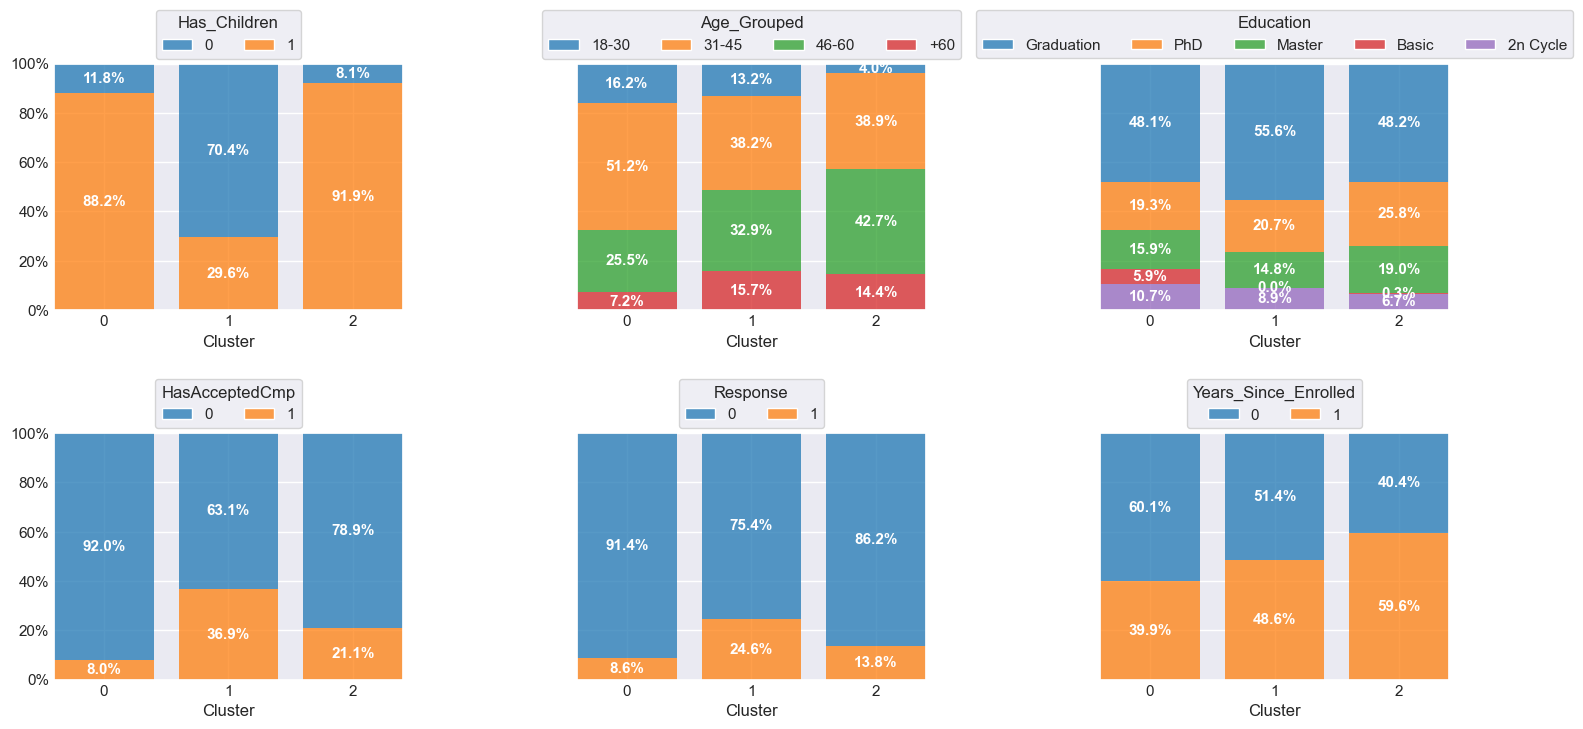

In [28]:
#Análise dos clusters em relação as features
plot_columns_percent_by_cluster(
    df_clustered, 
    categorical_columns, 
    rows_cols=(2, 3), 
    figsize=(18, 8),
    column_cluster="Cluster",
)

##### Observações
- Quase 70% das pessoas do cluster 1 não tem filhos, ao contrário dos demais demais clusters, nos quais por volta de 90% têm filhos. 
- Quanto a idade:
        - O Cluster 0 concentra 67% de pessoas entre 18 e 45 anos. Concentra a maior porção de pessoas com menos de 30 anos.
        - No Cluster 1 pessoas entre 31 e 60 anos representam a porção mais expressiva, seguidos pelas pessoas com mais 60 (15,5%). Concentra a maior porção de pessoas com mais de 60.
        - No Cluster 2 as pessoas com mais de 46 anos representam  56,8%.  Concentra a maior porção de pessoas com a idade variando entre 46 e 60 anos.
- Quanto a formação, pessoas com ensino básico só aparecem no Cluster 0.
- Quanto ao aceite de ofertas de campanhas e da campanha piloto:
        - o Cluster 1 traz os melhores resultados com mais de 10% de diferença em relação ao Cluster 2.
        - Já o aceite no Cluster 0 tem a menor taxa (por volta de 8%).

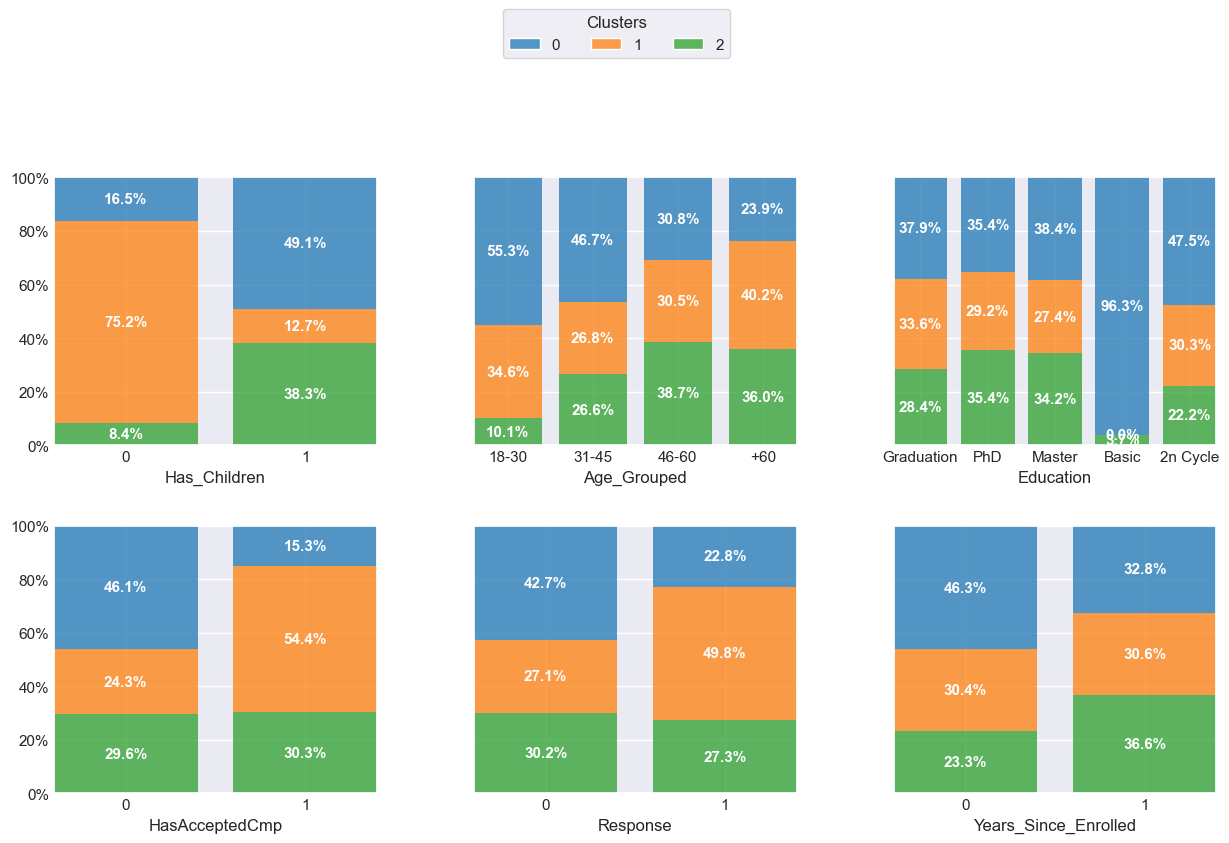

In [29]:
#Análise das features em relação aos clusters
plot_columns_percent_hue_cluster(
    df_clustered,
    categorical_columns,
    rows_cols=(2, 3),
    figsize=(15, 8),
    column_cluster="Cluster",
    palette="tab10",
)


##### Observações
- 75% dos clientes que não possuem filhos estão no Cluster 1.
- 55% das pessoas entre 18 e 30 anos estão no cluster 0 em contrapartida, 40% das pessoas com mais de 60 anos estão no Cluster 1.
- 96% das pessoas com ensino básico estão no Cluster 0
- Mais de 50% das pessoas que aceitaram ofertas de campanhas (incluindo a piloto) estão no grupo 1

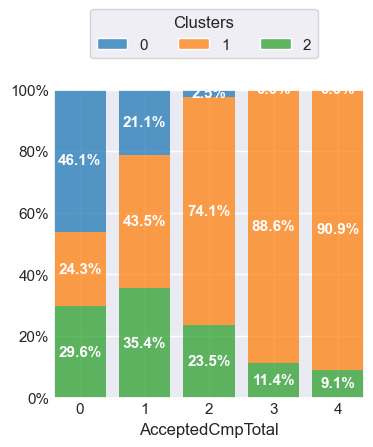

In [30]:
#análise feature 'AcceptedCmpTotal' - Aceites de ofertas em quantas campanhas promocionais
plot_columns_percent_hue_cluster(
    df_clustered,
    ['AcceptedCmpTotal'],
    rows_cols=(1, 1),
    figsize=(4, 4),
    column_cluster="Cluster",
    palette="tab10",
)


##### Observações

- Mais de 90% das pessoas que aceitou ofertas de 3 ou mais campanhas está no cluster 1, as demais (9%) no Cluster 2
- 74% das pessoas que aceitaram ofertas de 2 campanhas está no Cluster 1


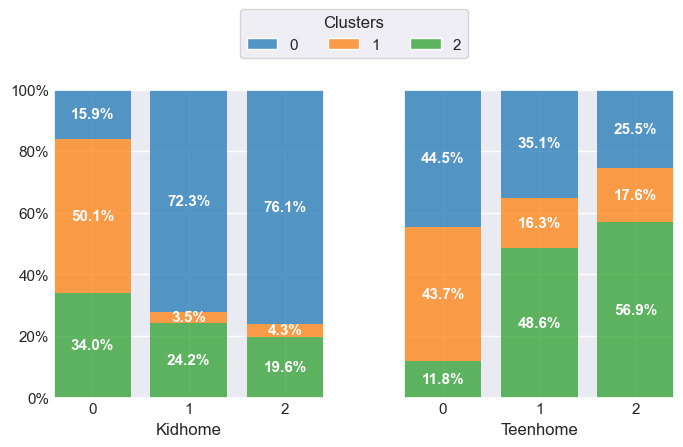

In [31]:
#análise feature 'AcceptedCmpTotal' - Aceites de ofertas em quantas campanhas promocionais
plot_columns_percent_hue_cluster(
    df_clustered,
    ['Kidhome', 'Teenhome'],
    rows_cols=(1, 2),
    figsize=(8, 4),
    column_cluster="Cluster",
    palette="tab10",
)


#### Observações

Nota-se que os clientes do Cluster 0 possuem mais filhos mais novos e as pessoas do Cluster 2 mais filhos adolescentes.

## Conclusão

Os clientes foram segmentados em 3 clusters:

##### Análise por cluster:

- Cluster 0:

  - Menor renda  
  - menor gasto 
  - maior probabilidade de ter filhos (jovens)
  - baixa propensão a aceitar campanhas
  - único cluster com porcentagem significativa de pessoas com escolaridade básica
  - grupo com pessoas mais jovens
  

- Cluster 1: 
 
  - Renda alta 
  - gasto alto 
  - menor probabilidade de ter filhos
  - mais propenso a aceitar campanhas
  - cluster sem pessoas com escolaridade básica
  - mais pessoas com idade intermediária/elevada
  

- Cluster 2: 
  - Renda intermediária
  - gasto intermediário
  - maior probabilidade de ter filhos (adolescentes)
  - pode aceitar campanhas
  - mais pessoas com idade intermediária/elevada


#### 📊 Insights Estratégicos com Base na Segmentação de Clientes
A combinação da análise exploratória com a segmentação por clusters revela três perfis distintos de clientes, permitindo à empresa adotar estratégias de marketing mais direcionadas e eficientes.

##### 🧩 Cluster 0 – Clientes com Menor Potencial de Consumo
Este grupo é formado por clientes com menor renda, baixo nível de gastos e maior presença de filhos jovens. É o único segmento com participação significativa de pessoas com formação básica e concentra clientes mais jovens. Eles demonstram baixa propensão a responder às campanhas promocionais.

🔹 Oportunidade: Estratégias de fidelização de longo prazo, ofertas mais acessíveis e campanhas educativas podem ser eficazes aqui, além de ações que incentivem o primeiro engajamento com a marca.

##### 💎 Cluster 1 – Clientes com Maior Potencial de Valor
Clientes desse grupo apresentam alta renda, maior volume de gastos, e raramente têm filhos. São os mais propensos a aceitar campanhas, com maior concentração de pessoas com nível educacional mais elevado e em faixa etária mais madura.

🔹 Oportunidade: Esse segmento é ideal para ofertas premium, programas de fidelidade e campanhas personalizadas. Representa um público estratégico, com grande potencial de conversão e geração de receita.

##### ⚖️ Cluster 2 – Clientes com Potencial Moderado
O terceiro grupo apresenta renda e gastos intermediários, e maior presença de filhos adolescentes. A aceitação de campanhas é possível, ainda que não tão expressiva quanto no Cluster 1. Também é formado por clientes com idade intermediária ou elevada.

🔹 Oportunidade: Estratégias híbridas podem ser adotadas, com foco em identificar gatilhos de engajamento que aumentem o envolvimento desse grupo com as campanhas. Incentivos moderados e segmentação por ciclo de vida familiar podem ser úteis.

#### 🎯 Direcionamento Estratégico
Essa segmentação permite que a empresa:

Personalize campanhas conforme o perfil do cliente.

Otimize o uso de recursos, focando esforços nos públicos com maior retorno esperado.

Aumente a conversão e fidelização, criando ações adequadas à realidade e ao comportamento de cada grupo.

Essa abordagem orientada por dados permite entender melhor o público, falar a língua de cada perfil e entregar mais valor ao cliente — transformando dados em decisões mais inteligentes para o negócio.



In [32]:
joblib.dump(pipeline, MODEL_CLUSTERING)

['D:\\ciencias_dados\\python_pratica\\hashtag\\ciencias_dados\\machine_learning\\projeto_clusterizacao_ifood_git\\models\\modelo_clustering.pkl']

In [34]:
df_clustered.to_parquet(CLUSTERED_DATA)